## Introduction to Neural Networks - Fraud Detection

Nilson reports that U.S. card fraud (credit, debt, etc) was reportedly 9 billion dollars in 2016 and expected to increase to 12 billion dollars by 2020. For perspective, in 2017 both PayPal's and Mastercard's revenue was only $10.8 billion each.


**Objective:** In this session, given the credit card transactions, we will build a simple neural network (i.e., Multilayer perceptrons) for Fraud Detection using Keras.

This notebooks covers,

1. Creating a Model

2. Adding Layers

3. Activations

4. Optimizers and Loss functions

5. Evaluation

### Dataset Description

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, the original features and more background information about the data is not provided. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Source: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [66]:
! pip install shap

     |████████████████████████████████| 358kB 6.1MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp36-cp36m-linux_x86_64.whl size=489394 sha256=08195eafc23109c8a14ad0a7ccf57b43476ec8d701851b0d2f1b02368c3d9043
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap


In [1]:
!pip install hiplot

     |████████████████████████████████| 757kB 6.4MB/s 
     |████████████████████████████████| 788kB 12.9MB/s 
     |████████████████████████████████| 368kB 35.1MB/s 
     |████████████████████████████████| 358kB 19.2MB/s 
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.14 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.16.1 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0


In [2]:
!pip install tensorflow==2.3

     |████████████████████████████████| 320.4MB 47kB/s 
     |████████████████████████████████| 20.1MB 22.5MB/s 
     |████████████████████████████████| 460kB 9.8MB/s 
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.16.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [4]:
import tensorflow as tf

In [5]:
print(tf.__version__)

2.3.0


In [5]:
!pip install keras
!pip install -U keras-tuner

     |████████████████████████████████| 71kB 4.3MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=8e08651ef7a5622baa1b805e9aebb421ee727275e9ba44b6fb32a78bdf889fc1
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=6f2735fafd05698e4b29a9f7615ea90ea20abd6cc887d6ea4e079d729cf61a27
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
import seaborn as sns
import matplotlib.pyplot as plt 
from kerastuner.tuners import RandomSearch
import hiplot as hip
from keras.utils.vis_utils import plot_model

In [7]:
from google.colab import drive

In [8]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
project_path = '/content/drive/MyDrive/GL_Mentor/Data/'

In [8]:
dataset_file = project_path + 'creditcard.csv'
dataset_file

'/content/drive/MyDrive/GL_Mentor/Data/creditcard.csv'

In [9]:
# Load Data File
data = pd.read_csv(dataset_file)

# Exploratory Data Analysis

In [10]:
data.head()

Time        V1        V2        V3  ...       V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  ...  0.133558 -0.021053  149.62      0
1   0.0  1.191857  0.266151  0.166480  ... -0.008983  0.014724    2.69      0
2   1.0 -1.358354 -1.340163  1.773209  ... -0.055353 -0.059752  378.66      0
3   1.0 -0.966272 -0.185226  1.792993  ...  0.062723  0.061458  123.50      0
4   2.0 -1.158233  0.877737  1.548718  ...  0.219422  0.215153   69.99      0

[5 rows x 31 columns]

In [13]:
# No missing values
data.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [14]:
data.describe(include='all').T

count          mean  ...            75%            max
Time    284807.0  9.481386e+04  ...  139320.500000  172792.000000
V1      284807.0  3.919560e-15  ...       1.315642       2.454930
V2      284807.0  5.688174e-16  ...       0.803724      22.057729
V3      284807.0 -8.769071e-15  ...       1.027196       9.382558
V4      284807.0  2.782312e-15  ...       0.743341      16.875344
V5      284807.0 -1.552563e-15  ...       0.611926      34.801666
V6      284807.0  2.010663e-15  ...       0.398565      73.301626
V7      284807.0 -1.694249e-15  ...       0.570436     120.589494
V8      284807.0 -1.927028e-16  ...       0.327346      20.007208
V9      284807.0 -3.137024e-15  ...       0.597139      15.594995
V10     284807.0  1.768627e-15  ...       0.453923      23.745136
V11     284807.0  9.170318e-16  ...       0.739593      12.018913
V12     284807.0 -1.810658e-15  ...       0.618238       7.848392
V13     284807.0  1.693438e-15  ...       0.662505       7.126883
V14     284807.0  1.479045e-15  ...       0.493150      10.526766
V15     284807.0  3.482336e-15  ...       0.648821       8.877742
V16     284807.0  1.392007e-15  ...       0.523296      17.315112
V17     284807.0 -7.528491e-16  ...       0.399675       9.253526
V18     284807.0  4.328772e-16  ...       0.500807       5.041069
V19     284807.0  9.049732e-16  ...       0.458949       5.591971
V20     284807.0  5.085503e-16  ...       0.133041      39.420904
V21     284807.0  1.537294e-16  ...       0.186377      27.202839
V22     284807.0  7.959909e-16  ...       0.528554      10.503090
V23     284807.0  5.367590e-16  ...       0.147642      22.528412
V24     284807.0  4.458112e-15  ...       0.439527       4.584549
V25     284807.0  1.453003e-15  ...       0.350716       7.519589
V26     284807.0  1.699104e-15  ...       0.240952       3.517346
V27     284807.0 -3.660161e-16  ...       0.091045      31.612198
V28     284807.0 -1.206049e-16  ...       0.078280      33.847808
Amount  284807.0  8.834962e+01  ...      77.165000   25691.160000
Class   284807.0  1.727486e-03  ...       0.000000       1.000000

[31 rows x 8 columns]

In [19]:
#All Numerical Variables

In [15]:
data.skew().sort_values(ascending=False)

Class     23.997579
Amount    16.977724
V28       11.192091
V21        3.592991
V7         2.553907
V6         1.826581
V10        1.187141
V4         0.676292
V26        0.576693
V9         0.554680
V11        0.356506
V19        0.109192
V13        0.065233
Time      -0.035568
V22       -0.213258
V18       -0.259880
V15       -0.308423
V25       -0.415793
V24       -0.552499
V16       -1.100966
V27       -1.170209
V14       -1.995176
V20       -2.037155
V3        -2.240155
V12       -2.278401
V5        -2.425901
V1        -3.280667
V17       -3.844914
V2        -4.624866
V23       -5.875140
V8        -8.521944
dtype: float64

In [16]:
data.kurt().sort_values(ascending=False)

V28       933.397502
Amount    845.092646
Class     573.887843
V23       440.088659
V7        405.607417
V20       271.016113
V27       244.989241
V8        220.586974
V21       207.287040
V5        206.904560
V2         95.773106
V17        94.799719
V6         42.642494
V1         32.486679
V10        31.988239
V3         26.619551
V14        23.879462
V12        20.241870
V16        10.419131
V25         4.290412
V9          3.731311
V22         2.832967
V4          2.635455
V18         2.578341
V19         1.724970
V11         1.633921
V26         0.919006
V24         0.618871
V15         0.284769
V13         0.195300
Time       -1.293530
dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


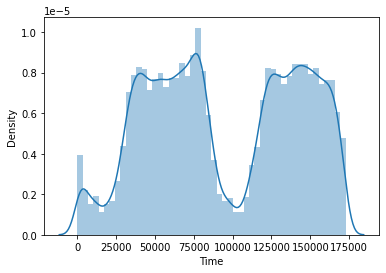

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


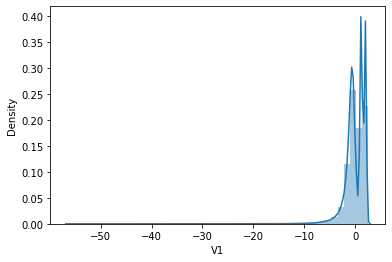

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


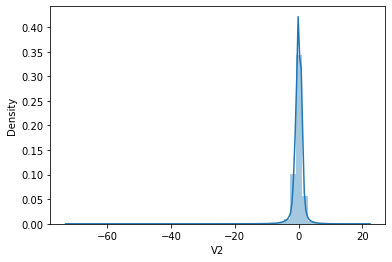

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


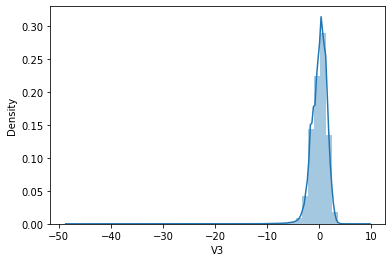

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


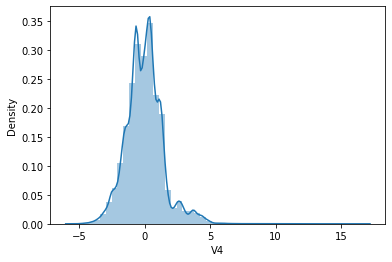

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


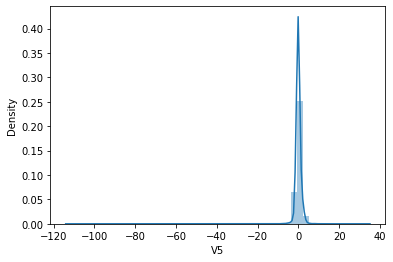

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


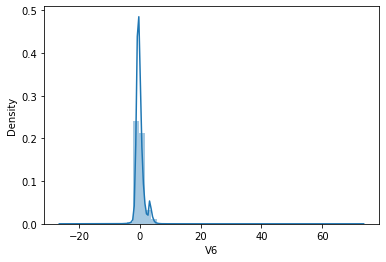

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


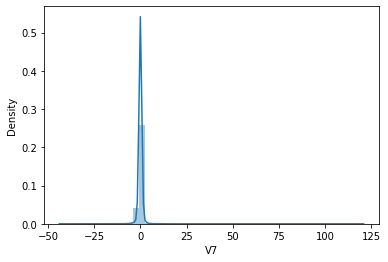

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


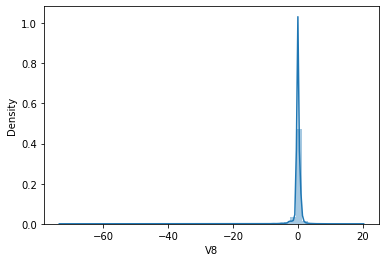

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


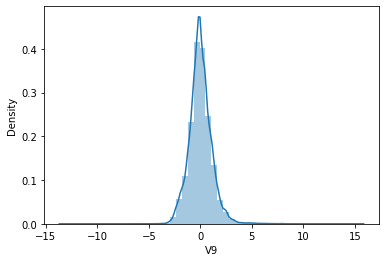

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


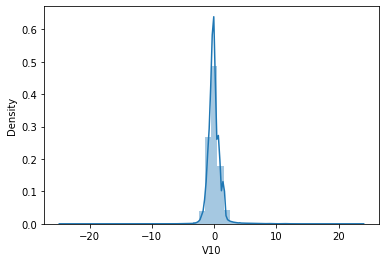

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


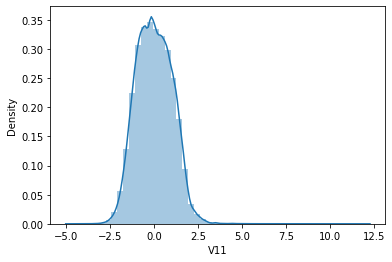

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


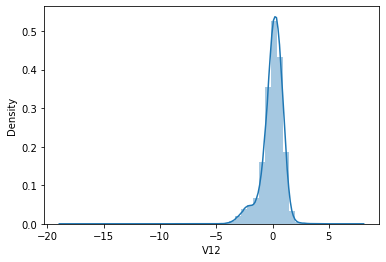

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


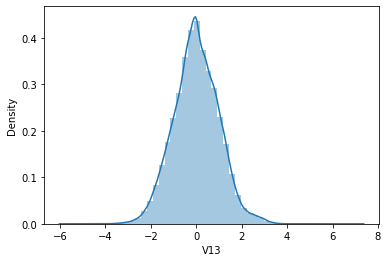

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


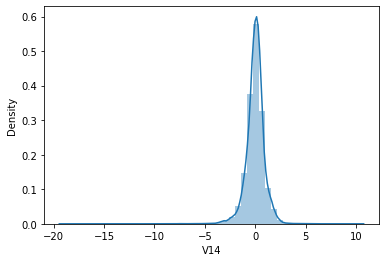

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


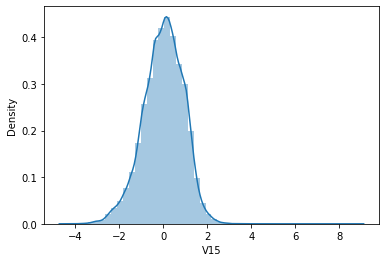

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


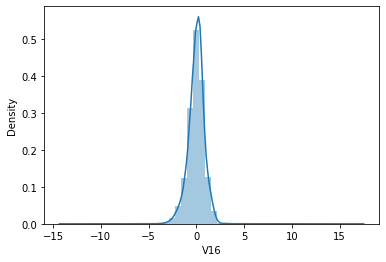

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


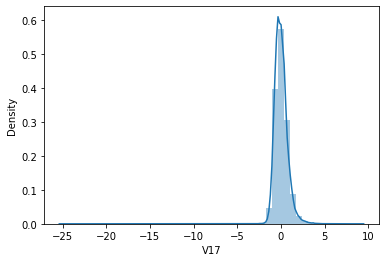

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


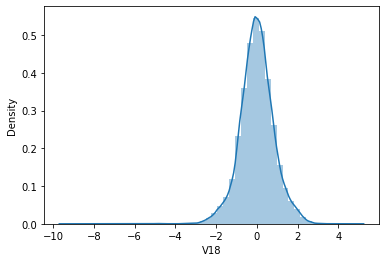

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


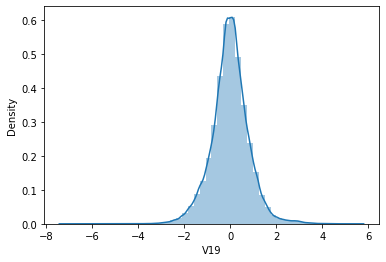

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


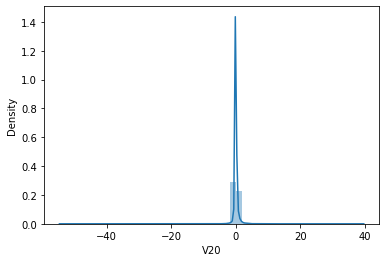

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


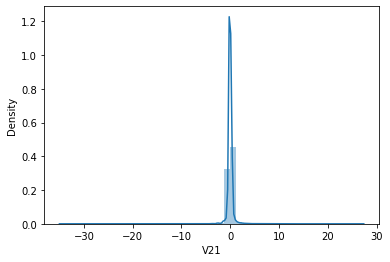

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


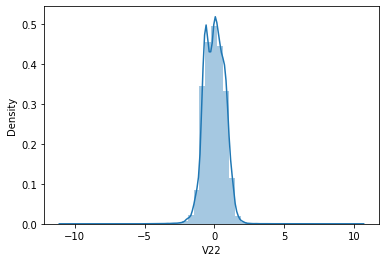

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


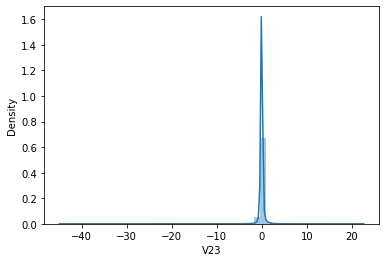

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


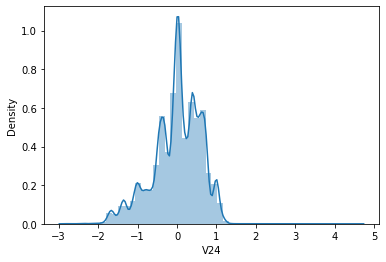

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


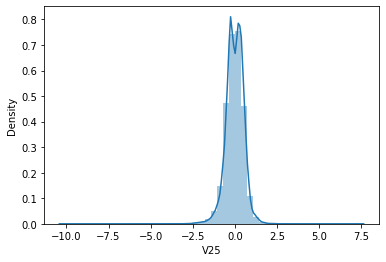

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


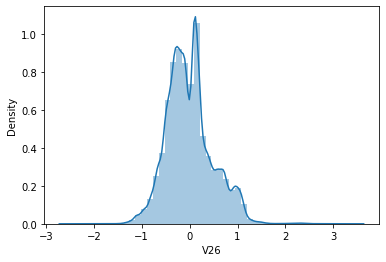

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


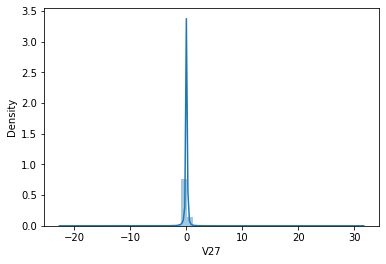

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


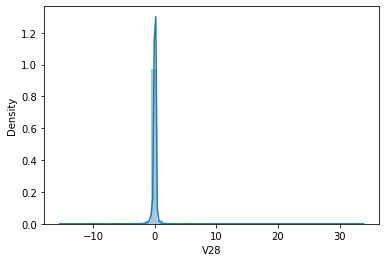

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


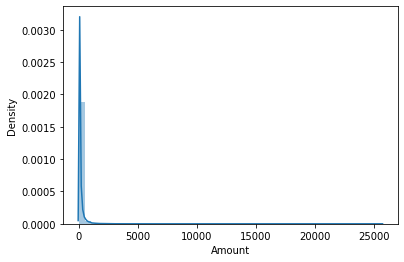

In [18]:
# Distribution Plots
for i,col in enumerate(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']):
    sns.distplot(data[col])
    plt.show()

In [11]:
#Drop time - Interpret as part of model
data = data.drop("Time", axis = 1)

In [129]:
# No strong correlations
data.corr()['Class'].sort_values()

V17      -0.326481
V14      -0.302544
V12      -0.260593
V10      -0.216883
V16      -0.196539
V3       -0.192961
V7       -0.187257
V18      -0.111485
V1       -0.101347
V9       -0.097733
V5       -0.094974
V6       -0.043643
V24      -0.007221
V13      -0.004570
V15      -0.004223
V23      -0.002685
V22       0.000805
V25       0.003308
V26       0.004455
Amount    0.005632
V28       0.009536
V27       0.017580
V8        0.019875
V20       0.020090
V19       0.034783
V21       0.040413
V2        0.091289
V4        0.133447
V11       0.154876
Class     1.000000
Name: Class, dtype: float64

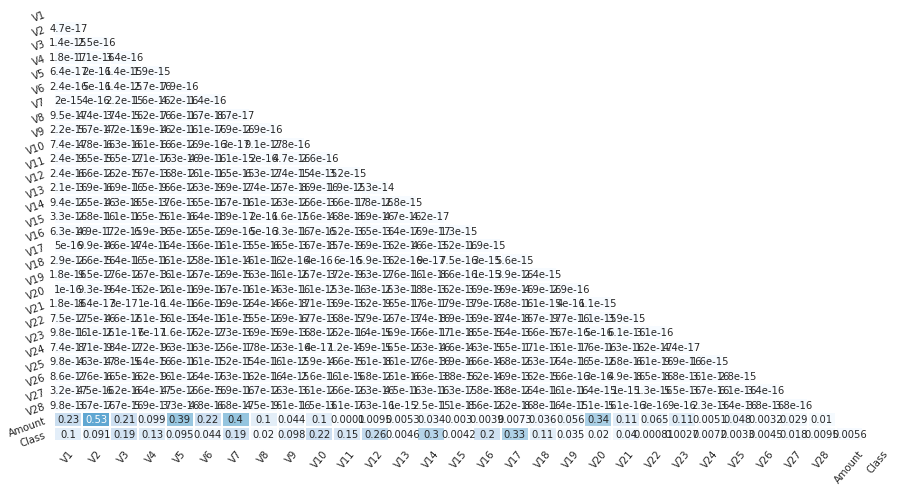

In [21]:
# No correlation between Principal Components as expected
corr = abs(data.corr()) # correlation matrix
lower_triangle = np.tril(corr, k = -1)  # select only the lower triangle of the correlation matrix
mask = lower_triangle == 0  # to mask the upper triangle in the following heatmap

plt.figure(figsize = (15,8))  # setting the figure size
sns.set_style(style = 'white')  # Setting it to white so that we do not see the grid lines
sns.heatmap(lower_triangle, center=0.5, cmap= 'Blues', annot= True, xticklabels = corr.index, yticklabels = corr.columns,
            cbar= False, linewidths= 1, mask = mask,fmt='.2g')   # Da Heatmap
plt.xticks(rotation = 50)   # Aesthetic purposes
plt.yticks(rotation = 20)   # Aesthetic purposes
plt.show()

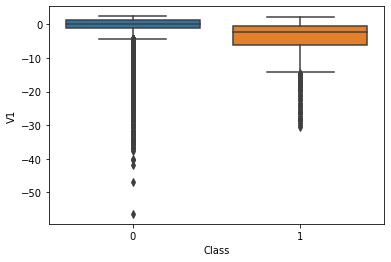

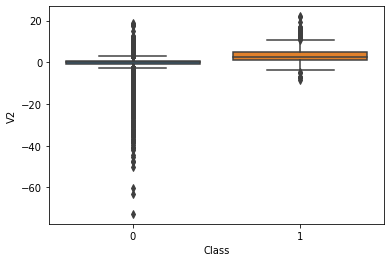

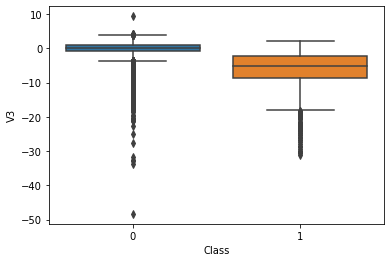

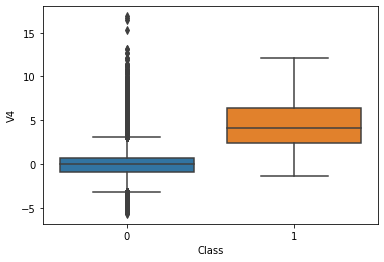

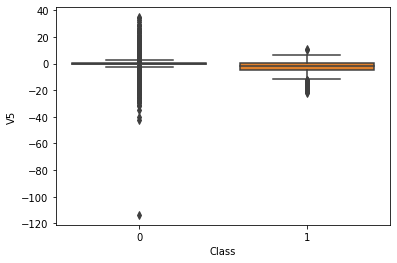

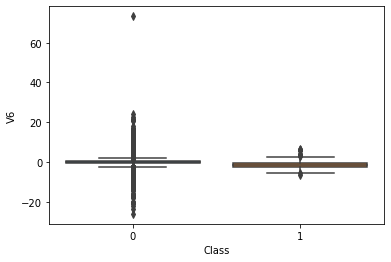

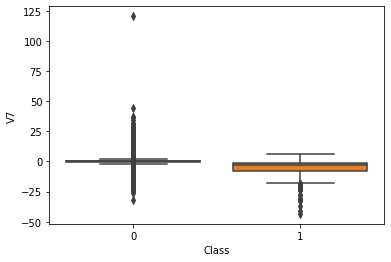

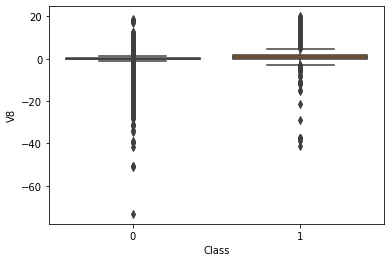

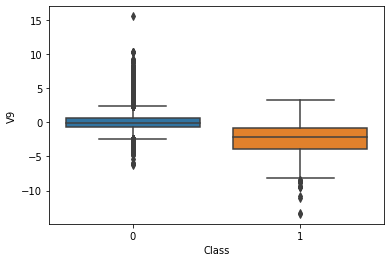

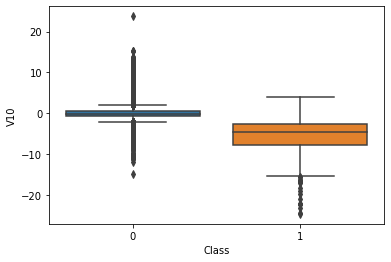

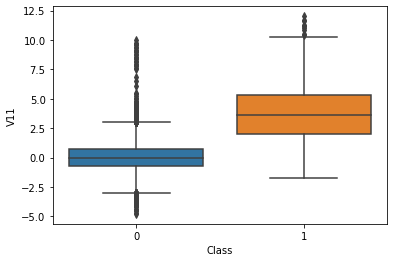

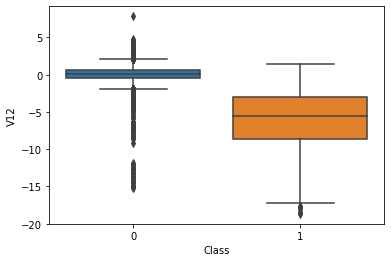

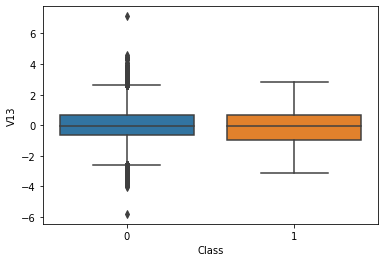

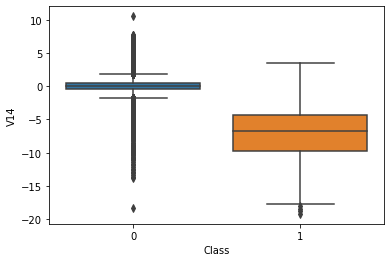

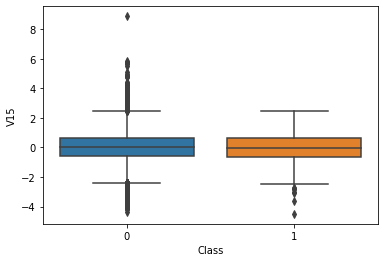

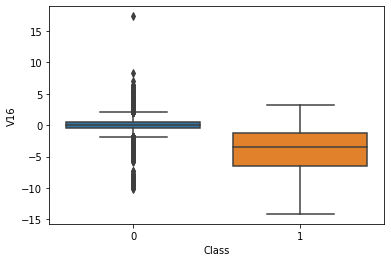

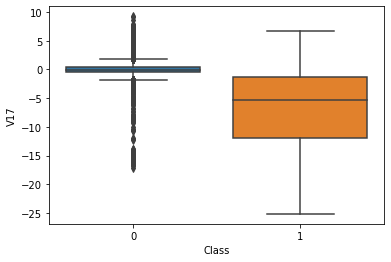

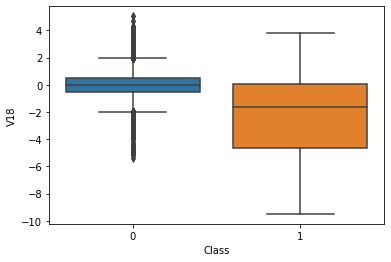

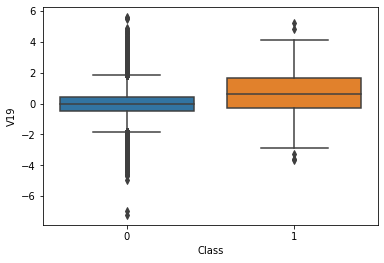

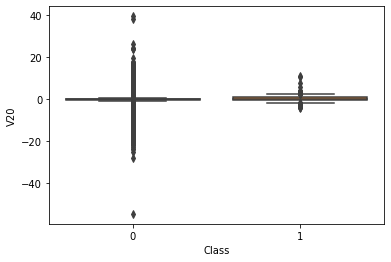

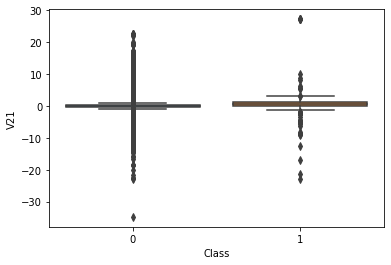

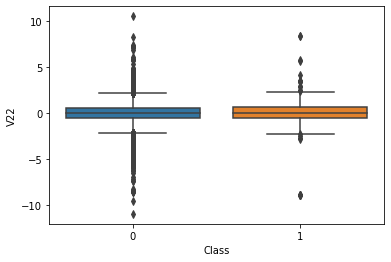

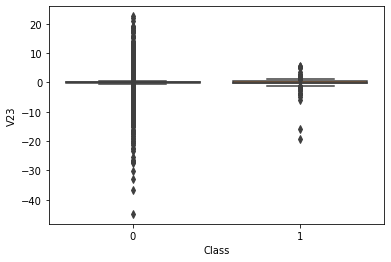

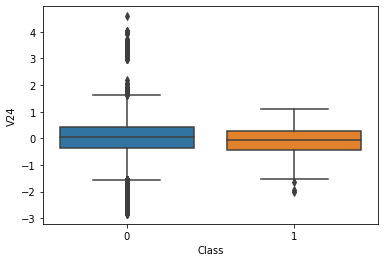

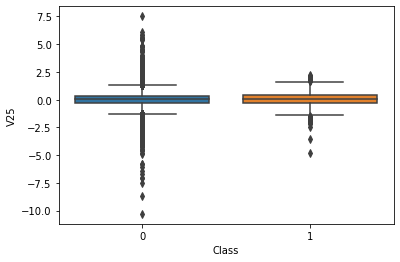

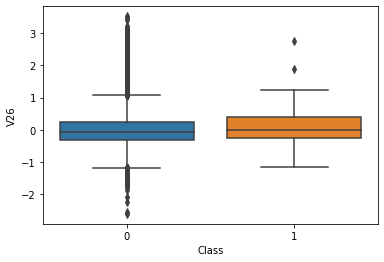

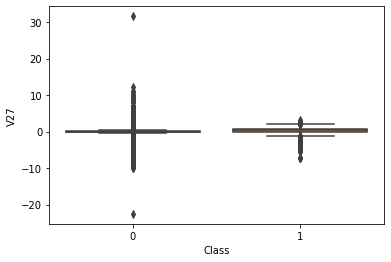

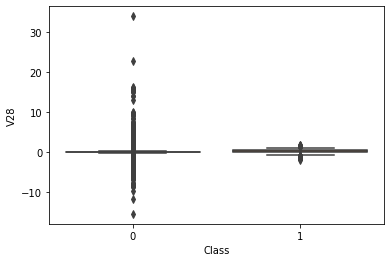

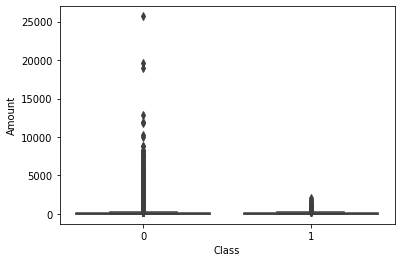

In [12]:
# Bi Variate Plots
for i,col in enumerate(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']):
    sns.boxplot(x='Class',y=col,data=data)
    plt.show()

In [11]:
# Check distributions for Class 0 vs 1
normal = data[data.Class==0]
fraud = data[data.Class==1]

In [12]:
normal.describe().T

count       mean         std  ...        50%        75%           max
V1      284315.0   0.008258    1.929814  ...   0.020023   1.316218      2.454930
V2      284315.0  -0.006271    1.636146  ...   0.064070   0.800446     18.902453
V3      284315.0   0.012171    1.459429  ...   0.182158   1.028372      9.382558
V4      284315.0  -0.007860    1.399333  ...  -0.022405   0.737624     16.875344
V5      284315.0   0.005453    1.356952  ...  -0.053457   0.612181     34.801666
V6      284315.0   0.002419    1.329913  ...  -0.273123   0.399619     73.301626
V7      284315.0   0.009637    1.178812  ...   0.041138   0.571019    120.589494
V8      284315.0  -0.000987    1.161283  ...   0.022041   0.326200     18.709255
V9      284315.0   0.004467    1.089372  ...  -0.049964   0.598230     15.594995
V10     284315.0   0.009824    1.044204  ...  -0.091872   0.455135     23.745136
V11     284315.0  -0.006576    1.003112  ...  -0.034923   0.736362     10.002190
V12     284315.0   0.010832    0.945939  ...   0.141679   0.619207      7.848392
V13     284315.0   0.000189    0.995067  ...  -0.013547   0.662492      7.126883
V14     284315.0   0.012064    0.897007  ...   0.051947   0.494104     10.526766
V15     284315.0   0.000161    0.915060  ...   0.048294   0.648842      8.877742
V16     284315.0   0.007164    0.844772  ...   0.067377   0.523738     17.315112
V17     284315.0   0.011535    0.749457  ...  -0.064833   0.399922      9.253526
V18     284315.0   0.003887    0.824919  ...  -0.002787   0.501103      5.041069
V19     284315.0  -0.001178    0.811733  ...   0.003117   0.457499      5.591971
V20     284315.0  -0.000644    0.769404  ...  -0.062646   0.132401     39.420904
V21     284315.0  -0.001235    0.716743  ...  -0.029821   0.185626     22.614889
V22     284315.0  -0.000024    0.723668  ...   0.006736   0.528407     10.503090
V23     284315.0   0.000070    0.621541  ...  -0.011147   0.147522     22.528412
V24     284315.0   0.000182    0.605776  ...   0.041082   0.439869      4.584549
V25     284315.0  -0.000072    0.520673  ...   0.016417   0.350594      7.519589
V26     284315.0  -0.000089    0.482241  ...  -0.052227   0.240671      3.517346
V27     284315.0  -0.000295    0.399847  ...   0.001230   0.090573     31.612198
V28     284315.0  -0.000131    0.329570  ...   0.011199   0.077962     33.847808
Amount  284315.0  88.291022  250.105092  ...  22.000000  77.050000  25691.160000
Class   284315.0   0.000000    0.000000  ...   0.000000   0.000000      0.000000

[30 rows x 8 columns]

In [13]:
fraud.describe().T

count        mean         std  ...       50%         75%          max
V1      492.0   -4.771948    6.783687  ... -2.342497   -0.419200     2.132386
V2      492.0    3.623778    4.291216  ...  2.717869    4.971257    22.057729
V3      492.0   -7.033281    7.110937  ... -5.075257   -2.276185     2.250210
V4      492.0    4.542029    2.873318  ...  4.177147    6.348729    12.114672
V5      492.0   -3.151225    5.372468  ... -1.522962    0.214562    11.095089
V6      492.0   -1.397737    1.858124  ... -1.424616   -0.413216     6.474115
V7      492.0   -5.568731    7.206773  ... -3.034402   -0.945954     5.802537
V8      492.0    0.570636    6.797831  ...  0.621508    1.764879    20.007208
V9      492.0   -2.581123    2.500896  ... -2.208768   -0.787850     3.353525
V10     492.0   -5.676883    4.897341  ... -4.578825   -2.614184     4.031435
V11     492.0    3.800173    2.678605  ...  3.586218    5.307078    12.018913
V12     492.0   -6.259393    4.654458  ... -5.502530   -2.974088     1.375941
V13     492.0   -0.109334    1.104518  ... -0.065566    0.672964     2.815440
V14     492.0   -6.971723    4.278940  ... -6.729720   -4.282821     3.442422
V15     492.0   -0.092929    1.049915  ... -0.057227    0.609189     2.471358
V16     492.0   -4.139946    3.865035  ... -3.549795   -1.226043     3.139656
V17     492.0   -6.665836    6.970618  ... -5.302949   -1.341940     6.739384
V18     492.0   -2.246308    2.899366  ... -1.664346    0.091772     3.790316
V19     492.0    0.680659    1.539853  ...  0.646807    1.649318     5.228342
V20     492.0    0.372319    1.346635  ...  0.284693    0.822445    11.059004
V21     492.0    0.713588    3.869304  ...  0.592146    1.244611    27.202839
V22     492.0    0.014049    1.494602  ...  0.048434    0.617474     8.361985
V23     492.0   -0.040308    1.579642  ... -0.073135    0.308378     5.466230
V24     492.0   -0.105130    0.515577  ... -0.060795    0.285328     1.091435
V25     492.0    0.041449    0.797205  ...  0.088371    0.456515     2.208209
V26     492.0    0.051648    0.471679  ...  0.004321    0.396733     2.745261
V27     492.0    0.170575    1.376766  ...  0.394926    0.826029     3.052358
V28     492.0    0.075667    0.547291  ...  0.146344    0.381152     1.779364
Amount  492.0  122.211321  256.683288  ...  9.250000  105.890000  2125.870000
Class   492.0    1.000000    0.000000  ...  1.000000    1.000000     1.000000

[30 rows x 8 columns]

### Split data into Train & Test Data for Modelling

In [12]:
X_data = data.iloc[:, :-1]

In [13]:
y_data = data.iloc[:, -1]

In [14]:
X_data.shape

(284807, 29)

In [15]:
X_data.head()

V1        V2        V3        V4  ...       V26       V27       V28  Amount
0 -1.359807 -0.072781  2.536347  1.378155  ... -0.189115  0.133558 -0.021053  149.62
1  1.191857  0.266151  0.166480  0.448154  ...  0.125895 -0.008983  0.014724    2.69
2 -1.358354 -1.340163  1.773209  0.379780  ... -0.139097 -0.055353 -0.059752  378.66
3 -0.966272 -0.185226  1.792993 -0.863291  ... -0.221929  0.062723  0.061458  123.50
4 -1.158233  0.877737  1.548718  0.403034  ...  0.502292  0.219422  0.215153   69.99

[5 rows x 29 columns]

In [16]:
y_data.shape

(284807,)

In [17]:
y_data.value_counts()/y_data.shape[0]*100
#Imbalanced Dataset

0    99.827251
1     0.172749
Name: Class, dtype: float64

In [18]:
y_data.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 7)

In [20]:
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

In [21]:
pd.DataFrame(X_train).describe().T

count      mean       std  ...       50%       75%       max
0   227845.0  0.020090  0.169515  ...  0.000200  0.048666  0.679608
1   227845.0  0.039479  0.105387  ...  0.001708  0.057646  0.582672
2   227845.0  0.003428  0.145447  ...  0.002752  0.042564  0.756269
3   227845.0  0.003411  0.128348  ... -0.000275  0.029535  0.771641
4   227845.0  0.021009  0.104514  ... -0.000936  0.034343  0.774611
5   227845.0 -0.019344  0.122664  ... -0.005129  0.006576  0.792578
6   227845.0  0.007294  0.081387  ...  0.000736  0.021547  0.493429
7   227845.0  0.001173  0.074156  ...  0.000333  0.011905  0.412679
8   227845.0  0.004908  0.093082  ... -0.000772  0.021100  0.630119
9   227845.0 -0.007278  0.087933  ... -0.001394  0.011469  0.660802
10  227845.0  0.004704  0.117611  ... -0.000436  0.024286  0.663654
11  227845.0  0.007224  0.097179  ...  0.002013  0.027710  0.509526
12  227845.0 -0.001770  0.113550  ... -0.000155  0.022972  0.694923
13  227845.0  0.000382  0.094975  ...  0.000585  0.020035  0.548457
14  227845.0  0.008297  0.101677  ...  0.000622  0.025535  0.560199
15  227845.0  0.008207  0.071163  ...  0.000913  0.026085  0.484076
16  227845.0 -0.004561  0.080844  ... -0.000841  0.011753  0.568781
17  227845.0 -0.003431  0.078200  ... -0.000068  0.016263  0.469908
18  227845.0  0.001328  0.077788  ...  0.000045  0.017369  0.778762
19  227845.0 -0.005010  0.034249  ... -0.001719  0.001983  0.267269
20  227845.0 -0.004773  0.046522  ... -0.000518  0.003775  0.626451
21  227845.0 -0.007493  0.081972  ...  0.000072  0.014867  0.548921
22  227845.0  0.000549  0.031431  ... -0.000247  0.005086  0.469663
23  227845.0  0.000359  0.067716  ...  0.000660  0.015349  0.809721
24  227845.0 -0.001106  0.056286  ...  0.000172  0.011680  0.545569
25  227845.0  0.001191  0.048024  ... -0.000505  0.013020  0.663246
26  227845.0  0.001707  0.031308  ...  0.000024  0.003905  0.253333
27  227845.0  0.000774  0.019207  ...  0.000175  0.002900  0.424011
28  227845.0  0.828423  0.276981  ...  0.981229  0.998394  0.999988

[29 rows x 8 columns]

In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(227845, 29)
(56962, 29)
(227845,)
(56962,)


### Creating a model

Keras model object can be created with Sequential class

At the outset, the model is empty per se. It is completed by adding additional layers and compilation


In [51]:
model = Sequential()

### Adding layers [layers and activations]

Keras layers can be added to the model

Adding layers are like stacking lego blocks one by one

It should be noted that as this is a classification problem, sigmoid layer (softmax for multi-class problems) should be added


In [52]:
model.add(Dense(64, input_shape = (29,), activation = 'relu'))
model.add(Dense(32, activation = 'tanh'))
model.add(Dense(1, activation = 'sigmoid'))
# method.add - add dense layer - fully connected, Play with ,kernel_initializer=,bias_initializer=

### Model compile [optimizers and loss functions]

Keras model should be "compiled" prior to training

Types of loss (function) and optimizer should be designated


In [53]:
sgd = optimizers.Adam(lr = 0.001)
#Optimization Function

In [54]:
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])
# Loss for compare and gives us the error,

### Summary of the model

In [55]:
model.summary()
# All parameters and network created to train

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                1920      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 4,033
Trainable params: 4,033
Non-trainable params: 0
_________________________________________________________________


### Training [Forward pass and Backpropagation]

Training the model

In [56]:
history = model.fit(X_train, y_train.values, batch_size = 700, epochs = 50, verbose = 1,validation_split=0.2)
# Training the model, You can use class_weight as a paramter for imbalanced here if no Over/Under Sampling performed

Epoch 1/50
261/261 [==============================] - 1s 3ms/step - loss: 0.0819 - accuracy: 0.9944 - val_loss: 0.0080 - val_accuracy: 0.9986
Epoch 2/50
261/261 [==============================] - 1s 2ms/step - loss: 0.0082 - accuracy: 0.9982 - val_loss: 0.0062 - val_accuracy: 0.9986
Epoch 3/50
261/261 [==============================] - 1s 2ms/step - loss: 0.0073 - accuracy: 0.9982 - val_loss: 0.0055 - val_accuracy: 0.9986
Epoch 4/50
261/261 [==============================] - 1s 2ms/step - loss: 0.0067 - accuracy: 0.9982 - val_loss: 0.0049 - val_accuracy: 0.9986
Epoch 5/50
261/261 [==============================] - 1s 2ms/step - loss: 0.0061 - accuracy: 0.9987 - val_loss: 0.0044 - val_accuracy: 0.9991
Epoch 6/50
261/261 [==============================] - 1s 2ms/step - loss: 0.0056 - accuracy: 0.9989 - val_loss: 0.0040 - val_accuracy: 0.9992
Epoch 7/50
261/261 [==============================] - 1s 2ms/step - loss: 0.0052 - accuracy: 0.9989 - val_loss: 0.0037 - val_accuracy: 0.9992
Epoch 

In [57]:
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

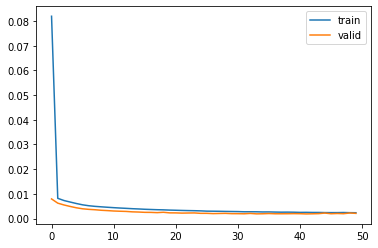

In [58]:
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)

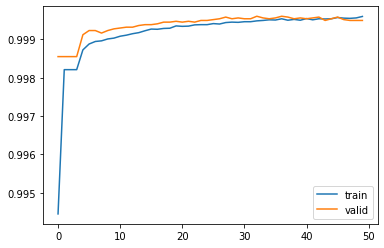

In [59]:
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.legend(("train" , "valid") , loc =0)

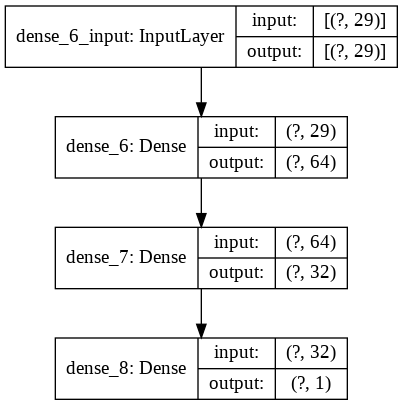

In [60]:
# Show the Model created
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [61]:
# How loss moves around with each epoch
data_vis = [{'epoch': idx, 
         'loss': history.history['loss'][idx],  
         'val_loss': history.history['val_loss'][idx], 
         'accuracy': history.history['accuracy'][idx], 
         'val_accuracy': history.history['val_accuracy'][idx]
         } for idx in range(20)]
hip.Experiment.from_iterable(data_vis).display()

<IPython.core.display.Javascript object>

### Evaluation
Keras model can be evaluated with evaluate() function

Evaluation results are contained in a list



In [62]:
results = model.evaluate(X_test, y_test.values)

1781/1781 [==============================] - 2s 920us/step - loss: 0.0039 - accuracy: 0.9994


In [63]:
print(model.metrics_names)
print(results)    

['loss', 'accuracy']
[0.003949766978621483, 0.9994031190872192]


### Confusion Matrix

In [64]:
Y_pred_cls = model.predict_classes(X_test, batch_size=200, verbose=0)
print('Accuracy Model1 (Dropout): '+ str(model.evaluate(X_test,y_test.values)[1]))
print('Recall_score: ' + str(recall_score(y_test.values,Y_pred_cls)))
print('Precision_score: ' + str(precision_score(y_test.values, Y_pred_cls)))
print('F-score: ' + str(f1_score(y_test.values,Y_pred_cls)))
confusion_matrix(y_test.values, Y_pred_cls)
#recall and precision high, Our model doing well

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
1781/1781 [==============================] - 1s 827us/step - loss: 0.0039 - accuracy: 0.9994
Accuracy Model1 (Dropout): 0.9994031190872192
Recall_score: 0.8
Precision_score: 0.851063829787234
F-score: 0.8247422680412372


array([[56848,    14],
       [   20,    80]])

In [65]:
# Predict using Threshold - Increase Probability increase threshold
pred_y = model.predict(X_test)
y_pred = (pred_y > 0.8)
print('Accuracy Model1 (Dropout): '+ str(accuracy_score(y_test.values,y_pred)))
#str(model.evaluate(X_test,y_test.values)[1]))
print('Recall_score: ' + str(recall_score(y_test.values,y_pred)))
print('Precision_score: ' + str(precision_score(y_test.values, y_pred)))
print('F-score: ' + str(f1_score(y_test.values,y_pred)))
confusion_matrix(y_test.values, y_pred)

Accuracy Model1 (Dropout): 0.9994557775359011
Recall_score: 0.75
Precision_score: 0.9259259259259259
F-score: 0.8287292817679557


array([[56856,     6],
       [   25,    75]])

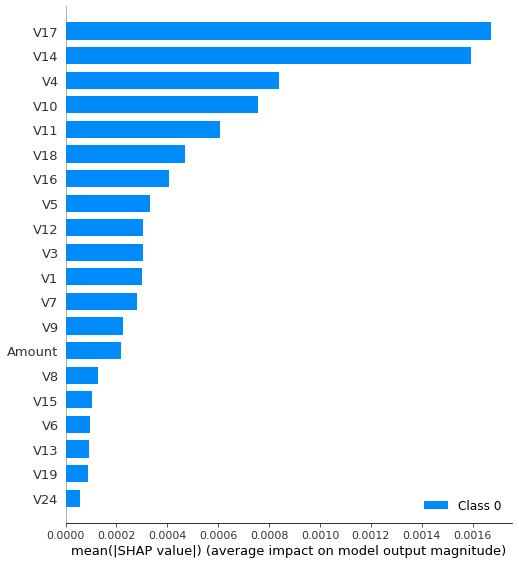

In [68]:
## Explain Model Better using SHAP ( Similar to LIME used before ) - Feature Importance
import shap
shap.initjs()
explainer = shap.DeepExplainer(model, X_train[:1000]) 
shap_values = explainer.shap_values(X_test[:1000])
shap.summary_plot(shap_values, pd.DataFrame(X_test,columns = X_data.columns), plot_type='bar')

### Keras Functional API

In [73]:
# Keras Functional API - better use cases when we work on Computer Vision / Embedding problems.
from keras.layers import Input
from keras.layers import concatenate
from keras import Model
inputs = Input(shape=(29,)) 
dense_relu_1 = Dense(32, activation='relu')(inputs) 
dense_sigmoid_1 = Dense(32, activation='sigmoid')(inputs) 
dense_relu_2 = Dense(32, activation='relu')(dense_relu_1)
dense_tanh_2 = Dense(32, activation='tanh')(dense_sigmoid_1)
concat = concatenate([dense_relu_2, dense_tanh_2]) #concatenate these two nodes into one large vector
outputs = Dense(1)(concat) #pass concat into an outputs layer
model_func = Model(inputs=inputs, outputs=outputs, name='nonlinear_model') #compile inputs and outputs into one Model

In [74]:
# summarize layers
print(model_func.summary())


Model: "nonlinear_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 29)]         0                                            
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 32)           960         input_3[0][0]                    
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 32)           960         input_3[0][0]                    
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 32)           1056        dense_18[0][0]                   
____________________________________________________________________________________

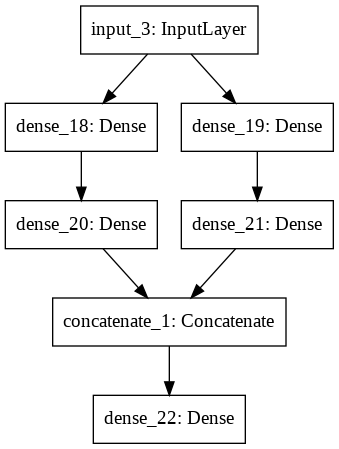

In [75]:
# plot graph - using same input layer across multiple hidden layers
plot_model(model_func, to_file='Model_Functional_API.png')

In [77]:
sgd = optimizers.Adam(lr = 0.001)
model_func.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])
history = model_func.fit(X_train, y_train.values, batch_size = 700, epochs = 50, validation_split=0.2,verbose=0)

In [78]:
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

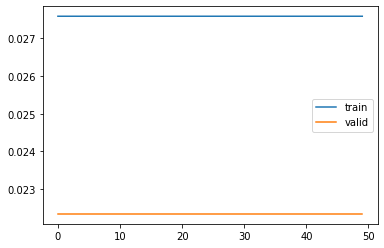

In [79]:
# Functional API Network doesnt reduce error
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)

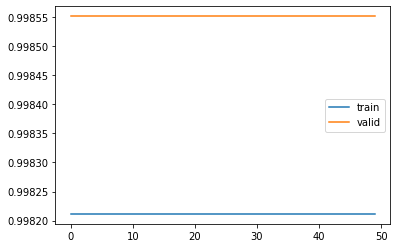

In [80]:
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.legend(("train" , "valid") , loc =0)

In [82]:
results = model_func.evaluate(X_test, y_test.values)
print(model_func.metrics_names)
print(results)

1781/1781 [==============================] - 2s 1ms/step - loss: 0.0271 - accuracy: 0.9982
['loss', 'accuracy']
[0.027079343795776367, 0.9982444643974304]


#### Feel free to experiment with the model and get to better evaluation metric scores. 
Happy Learning!

# HyperParameter Tuning

In [23]:
def build_model(hp):
    model_1 = Sequential() #Start model
    model_1.add(Dense(units=hp.Int('units_in',min_value=16,max_value=256,step=32),  
                    input_shape = (29,), 
                    activation = hp.Choice('act_in', ['relu', 'tanh']))) # Hidden Layer connected to Input Layer
    for i in range(hp.Int('num_layers', 0, 2)):
      model_1.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation=hp.Choice('act_' + str(i), ['relu', 'tanh'])))  # Hidden Layer
      model_1.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.3))) # Drop out layer for regularization

    model_1.add(Dense(1, activation='sigmoid')) # Output layer
      
    model_1.compile(
         optimizer=optimizers.Adam(
             hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
             loss='binary_crossentropy',
             metrics=['accuracy'])
      
    return model_1

In [29]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='Fraud_Dir',
    project_name='Fraud_Proj4')
# Test against kernel_initializer and bias_initializer values as well


In [33]:
tuner.search_space_summary()

Search space summary
Default search space size: 9
units_in (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 32, 'sampling': None}
act_in (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
act_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
act_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': [

In [31]:
tuner.search(X_train, y_train.values , epochs = 5,validation_split=0.1)

Trial 5 Complete [00h 06m 18s]
val_accuracy: 0.9993855655193329

Best val_accuracy So Far: 0.9993855655193329
Total elapsed time: 00h 18m 02s
INFO:tensorflow:Oracle triggered exit


In [34]:
#Summary of best results
print(tuner.results_summary())

Results summary
Results in Fraud_Dir/Fraud_Proj4
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units_in: 80
act_in: tanh
num_layers: 2
learning_rate: 0.001
units_0: 480
act_0: tanh
dropout: 0.4
units_1: 384
act_1: relu
Score: 0.9993855655193329
Trial summary
Hyperparameters:
units_in: 208
act_in: tanh
num_layers: 0
learning_rate: 0.01
units_0: 384
act_0: relu
dropout: 0.1
units_1: 448
act_1: tanh
Score: 0.9993636012077332
Trial summary
Hyperparameters:
units_in: 176
act_in: tanh
num_layers: 2
learning_rate: 0.01
units_0: 416
act_0: tanh
dropout: 0.30000000000000004
units_1: 320
act_1: tanh
Score: 0.9993416666984558
Trial summary
Hyperparameters:
units_in: 48
act_in: tanh
num_layers: 1
learning_rate: 0.001
units_0: 64
act_0: tanh
dropout: 0.30000000000000004
units_1: 160
act_1: tanh
Score: 0.9993197321891785
Trial summary
Hyperparameters:
units_in: 80
act_in: tanh
num_layers: 2
learning_rate: 0.0001
units_0: 32
act_0: relu
dropout:

In [50]:
# Best Hyperparameter model using Randomized Search CV - This can change on individual machines
print(tuner.get_best_hyperparameters()[0].values)

{'units_in': 80, 'act_in': 'tanh', 'num_layers': 2, 'learning_rate': 0.001, 'units_0': 480, 'act_0': 'tanh', 'dropout': 0.4, 'units_1': 384, 'act_1': 'relu'}


In [36]:
print(tuner.get_best_models()[0].summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                2400      
_________________________________________________________________
dense_1 (Dense)              (None, 480)               38880     
_________________________________________________________________
dropout (Dropout)            (None, 480)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 384)               184704    
_________________________________________________________________
dropout_1 (Dropout)          (None, 384)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 385       
Total params: 226,369
Trainable params: 226,369
Non-trainable params: 0
__________________________________________________

In [37]:
# Run test data against best Hyperparametrized Model
best_model = tuner.get_best_models(num_models=1)[0]
results = best_model.evaluate(X_test, y_test.values)

1781/1781 [==============================] - 3s 2ms/step - loss: 0.0137 - accuracy: 0.9994


In [39]:
import os
import json

vis_data = []
rootdir = 'Fraud_Dir/Fraud_Proj4'
for subdirs, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith("trial.json"):
          with open(subdirs + '/' + file, 'r') as json_file:
            data = json_file.read()
          vis_data.append(json.loads(data))

In [42]:
# Find relationship between hyperparameter and loss values using a Visualization
data = [{'act_0': vis_data[idx]['hyperparameters']['values']['act_0'],
         'act_1': vis_data[idx]['hyperparameters']['values']['act_1'], 
         'act_in': vis_data[idx]['hyperparameters']['values']['act_in'], 
         'dropout': vis_data[idx]['hyperparameters']['values']['dropout'], 
         'learning_rate': vis_data[idx]['hyperparameters']['values']['learning_rate'], 
         'num_layers': vis_data[idx]['hyperparameters']['values']['num_layers'], 
         'units_0': vis_data[idx]['hyperparameters']['values']['units_0'], 
         'units_1': vis_data[idx]['hyperparameters']['values']['units_1'], 
         'units_1': vis_data[idx]['hyperparameters']['values']['units_in'], 
         'loss': vis_data[idx]['metrics']['metrics']['loss']['observations'][0]['value'],  
         'val_loss': vis_data[idx]['metrics']['metrics']['val_loss']['observations'][0]['value'], 
         'accuracy': vis_data[idx]['metrics']['metrics']['accuracy']['observations'][0]['value'],
         'val_accuracy': vis_data[idx]['metrics']['metrics']['val_accuracy']['observations'][0]['value']} for idx in range(5)]

hip.Experiment.from_iterable(data).display()

<IPython.core.display.Javascript object>

In [43]:
print(best_model.metrics_names)
print(results)  

['loss', 'accuracy']
[0.01372815202921629, 0.9993680119514465]


In [46]:
Y_pred_cls = best_model.predict_classes(X_test, batch_size=200, verbose=0)
print('Accuracy Model1 (Dropout): '+ str(best_model.evaluate(X_test,y_test.values)[1]))
print('Recall_score: ' + str(recall_score(y_test.values,Y_pred_cls)))
print('Precision_score: ' + str(precision_score(y_test.values, Y_pred_cls)))
print('F-score: ' + str(f1_score(y_test.values,Y_pred_cls)))
confusion_matrix(y_test.values, Y_pred_cls)

1781/1781 [==============================] - 3s 2ms/step - loss: 0.0137 - accuracy: 0.9994
Accuracy Model1 (Dropout): 0.9993680119514465
Recall_score: 0.77
Precision_score: 0.8555555555555555
F-score: 0.8105263157894737


array([[56849,    13],
       [   23,    77]])

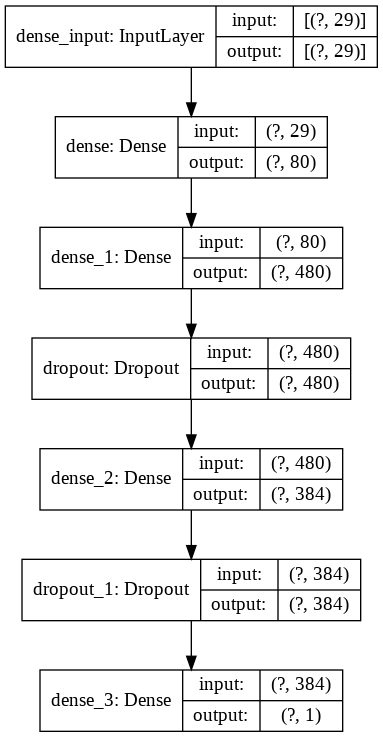

In [49]:
#Best Model plot
plot_model(best_model, to_file='best_model_plot.png', show_shapes=True, show_layer_names=True)

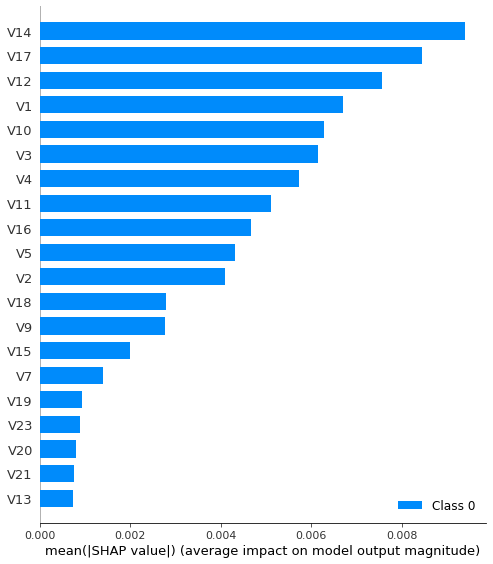

In [48]:
## Explain Model Better using Shap
import shap
shap.initjs()
explainer = shap.DeepExplainer(best_model, X_train[:1000]) # 
shap_values = explainer.shap_values(X_test[:1000])# X_test[:1000]
shap.summary_plot(shap_values, pd.DataFrame(X_test,columns = X_data.columns), plot_type='bar')

In [ ]:
#Alternate way to get best model
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hyperparameters)
history = model.fit(trainX, trainY,
                      epochs=5,
                      validation_data=(testX, testY))

KERAS REFERENCE
https://keras.io/api/


In [ ]:
####################################################################################################